In [1]:
# !python -m pip install "gymnasium[atari]"
# !python -m pip install "gymnasium[accept-rom-license, atari]"
# !pip install shimmy

In [2]:
import matplotlib.pyplot as plt
import gymnasium as gym
import seaborn as sns
import numpy as np

import warnings
import ale_py
import shimmy
import joblib
import os

from gym import wrappers

| **Value** | **Meaning** |
|:---------:|:-----------:|
| 0 | NOOP |
| 1 | FIRE |
| 2 | RIGHT |
| 3 | LEFT |
| 4 | RIGHTFIRE |
| 5 | LEFTFIRE |

# General Functions

In [3]:
def show_obs(obs):
    """ 
    Simple display of image observation 
    
    Args:
    `obs` : np.ndarray
    - Observation from the environment
    """
    plt.figure(figsize=(16,10))
    plt.imshow(obs)
    plt.show()
    return

# Run Constants

In [4]:
# Config flags - video output and res
resume = True # resume training from previous checkpoint (from save.p  file)?
render = False # render video output?
print_ = False # print each observation
show = False
no_grad = False
corner_correct = False

timer_i = 1000 # number of iterations without reward before noise is intentionally greater than signal

record_probs = True
record_rewards = True
record_eps_iters = True
save_path = 'model.pt'

# Model Instantiation

In [5]:
OBS_SHAPE = (210, 160)
XMIN = 26
XMAX = 196
YMIN = 14
YMAX = 144
SHAPE = (XMAX - XMIN, YMAX - YMIN)
DOWNSAMPLE = False
DIM = np.prod(SHAPE) // 4 if DOWNSAMPLE else np.prod(SHAPE)

action_dict = {
    0 : 'NOOP',
    1 : 'FIRE',
    2 : 'RIGHT',
    3 : 'LEFT',
    4 : 'RIGHTFIRE',
    5 : 'LEFTFIRE'
}
ACTIONS = [0,1,2,3,4,5] # modify to limit available actions
N_CLASSES = len(ACTIONS)

print('Input Shape:', SHAPE)
print('Input Dimensionality:', DIM)

def preprocess(obs, downsample=True, xmin=26, xmax=196, ymin=10, ymax=144):
    assert obs.shape == (210, 160)
    I = obs[xmin:xmax,ymin:ymax] # crop - remove 35px from start & 25px from end of image in x, to reduce redundant parts of image (i.e. after ball passes paddle)
    if downsample:
        I = I[::2,:]
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else to 1
#     return I.astype(np.float32).ravel() # ravel flattens an array and collapses it into a column vector
    obs = torch.from_numpy(I.ravel()).double().unsqueeze(dim=0)
    return obs

Input Shape: (170, 130)
Input Dimensionality: 22100


In [6]:
prev_x = None # used in computing the difference frame

dlogps, drs = list(), list()
running_reward = None

reward_sum = 0
adj_reward_sum = 0

In [7]:
def add_noise(probs, i, i_since_r, timer_i, buffer=None, print_=False):
    # autograd no inplace ops
    if buffer is None:
        buffer = timer_i // 2
    n = len(probs)
    sigma = 2 / n
    noise = torch.normal(0, sigma, n) # means, stds shared, size n
    noise = noise - noise.mean()
    
    scale = i_since_r / (timer_i - buffer)
    noise = noise * scale
    assert not round(noise.mean(), 3), noise
    new_probs = probs + noise
    pmin = torch.min(new_probs)
    if pmin < 0:
        new_probs = new_probs - pmin
        new_probs = new_probs / np.sum(new_probs)
    return new_probs

def balance_lr(probs, i_since_r, timer_i, buffer=None):
#    ACTIONS = [NOOP,1,2,3,4,5]
    raise NotImplementedError()
    if i_since_r < timer_i // 4:
        pass
    elif i_since_r < timer_i // 2:
        equal_n = (probs[2] + probs[3]) / 2
        equal_y = (probs[4] + probs[5]) / 2
        probs[2] = equal_n
        probs[3] = equal_n
        probs[4] = equal_y
        probs[5] = equal_y
    elif i_since_r < 3 * timer_i // 4:
        probs[2], probs[3] = probs[3], probs[2]
        probs[4], probs[5] = probs[5], probs[4]
    return probs
    
def modify_reward(action, reward, info, prev_lives):
    if info['lives'] < prev_lives:
        reward -= 15
    if reward <= 0 and action in [1,4,5]:
        reward -= 1
    return reward

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

class TwoLayerReinforcement(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TwoLayerReinforcement, self).__init__()
        
        self.log_probss = list()
        self.rewards = list()
        
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.activation = nn.ReLU()
        self.layer2 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=-1)
        return
        
    def forward(self, x):
        assert len(x.shape) == 2
        x = self.layer1(x)
        x = self.activation(x)
        x = self.layer2(x)
        probs = self.softmax(x)
#         probs = torch.nn.functional.softmax(x, dim=0)
        return probs

In [9]:
model = TwoLayerReinforcement(DIM, 64, 6).double()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
eps = np.finfo(np.float32).eps.item()

In [10]:
n_episodes = 665
batch_size = 64
last_i = 0
env = gym.make(
    'ALE/DemonAttack-v5', # alternate games can be chosen here 
    obs_type='grayscale', # saves RGB preprocessing reduction
    render_mode='human' if render else None, # rendering shows popup but limits training speed
)
        
if record_rewards:
    reward_list = list()
if record_probs:
    prob_list = list()
if record_eps_iters:
    eps_iters_list = list()

def process_probs(probs, i, last_i, timer_i=1000, corner_correct=True):
    initial_shape = probs.shape
    i_since_r = i - last_i
    if i_since_r > timer_i:
        terminated = True
        truncated = False
        print('Timer causing reset               ')
    else:
        terminated = False
        truncated = False
        
    if corner_correct: # heavily biases agent from getting 'stuck' in corner
        probs = add_noise(probs, i, i_since_r, timer_i)
        probs = balance_lr(probs, i_since_r, timer_i)

    if torch.round(torch.sum(probs), decimals=4) != 1:
        warnings.warn(str(probs) + ' | ' + str(torch.sum(probs)) + ' != 1')
        probs = probs / torch.sum(probs)
        
    assert probs.shape == initial_shape
    return probs, i, terminated, truncated


def discount_rewards(rewards, gamma=.99):
    """ 
    Take 1D array of rewards and compute discounted version
    Most recent action has the greatest weight 

    Args:
    `rewards` : np.ndarray
    - Observed rewards over time
    - ndim : 1
    """
    discounted_rewards = torch.empty(len(rewards)).double()
#     discounted_rewards = deque()
    running_add = 0
    for i, reward in zip(range(len(rewards) - 1, -1, -1), rewards):
        running_add = running_add * gamma + reward  
        discounted_rewards[i] = running_add
#     discounted_rewards = torch.as_tensor(discounted_rewards)
    return discounted_rewards

def standardize(returns):
    returns = (returns - returns.mean()) / (returns.std() + eps)
    return returns

episode_number = 0
prev_lives = 0
i = 0

obs, info = env.reset()
while episode_number <= n_episodes:
    curr_x = preprocess(obs, downsample=DOWNSAMPLE, xmin=XMIN, xmax=XMAX, ymin=YMIN, ymax=YMAX)
    x = curr_x - prev_x if prev_x is not None else torch.zeros((1, DIM)).double() # only monitor change between frames
    prev_x = curr_x
    assert x.dim() == 2, x.dim()
    model_probs = model(x) # autograd performed here
    probs, last_i, terminated, truncated = process_probs(model_probs, i, last_i, timer_i=timer_i, corner_correct=corner_correct)
    
    if record_probs:
        prob_list.append(probs)
        
    m = torch.distributions.Categorical(probs)
    action = m.sample()
    log_probs = m.log_prob(action)
    model.log_probss.append(log_probs)
    action = action.item()
    
    ######################################################################################
    # fold this into model
    # fix log probs here
    # https://github.com/pytorch/examples/blob/main/reinforcement_learning/reinforce.py
    # log_prob = prob.clamp(min=1e-6).log()
    # entropy = - (probs * probs.clamp(min=1e-6).log()).sum()
    # https://discuss.pytorch.org/t/policy-gradient-using-loss-as-reward/13877
    ######################################################################################
    
    prev_lives = info['lives'] # lives not available through general step return
    obs, reward, terminated, truncated, info = env.step(action) # step returns all other relevant information 
    if reward > 0: # reset the iterations since last reward if reward is accrued
        last_i = i

    reward_sum += reward # total round reward incremented
#     adj_reward = modify_reward(action, reward, info, prev_lives) # adjusted reward may better lead agent toward short term optimums
    adj_reward = reward
    adj_reward_sum += adj_reward

    model.rewards.append(adj_reward)
    ######################################################

    if terminated: # an episode finished
        episode_number += 1

        # Finish The Episode
        if not no_grad and not episode_number % batch_size:
            assert len(model.log_probss)
            assert len(model.rewards)

            discounted_rewards = discount_rewards(model.rewards)
            discounted_rewards = standardize(discounted_rewards)
            episode_losss = [(-log_prob * reward).unsqueeze(dim=0) for log_prob, r in zip(model.log_probss, discounted_rewards)]
    
            optimizer.zero_grad()
            loss = torch.cat(episode_losss).double().sum()
            loss.backward()
            optimizer.step()
                
            model.log_probss.clear()
            model.rewards.clear()

        if record_rewards:
            reward_list.append(reward_sum)

        reward_sum = 0 # reset all totals
        adj_reward_sum = 0
        
        obs, info = env.reset() # reset env
        prev_x = None
    elif truncated: # an episode terminated unexpectedly, shouldn't maintain results
        model.log_probss.clear()
        model.rewards.clear()
        
        reward_sum = 0
        adj_reward_sum = 0
        
        obs, info = env.reset()
        prev_x = None
           
    if not i % 100:
        print(f'Episode {episode_number} of {n_episodes} episodes                ', end='\r')
        torch.save(model, save_path)
    i += 1

env.close()

C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\utils\passive_env_checker.py:42: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (210, 160)
  logger.warn(


(673503, 6)

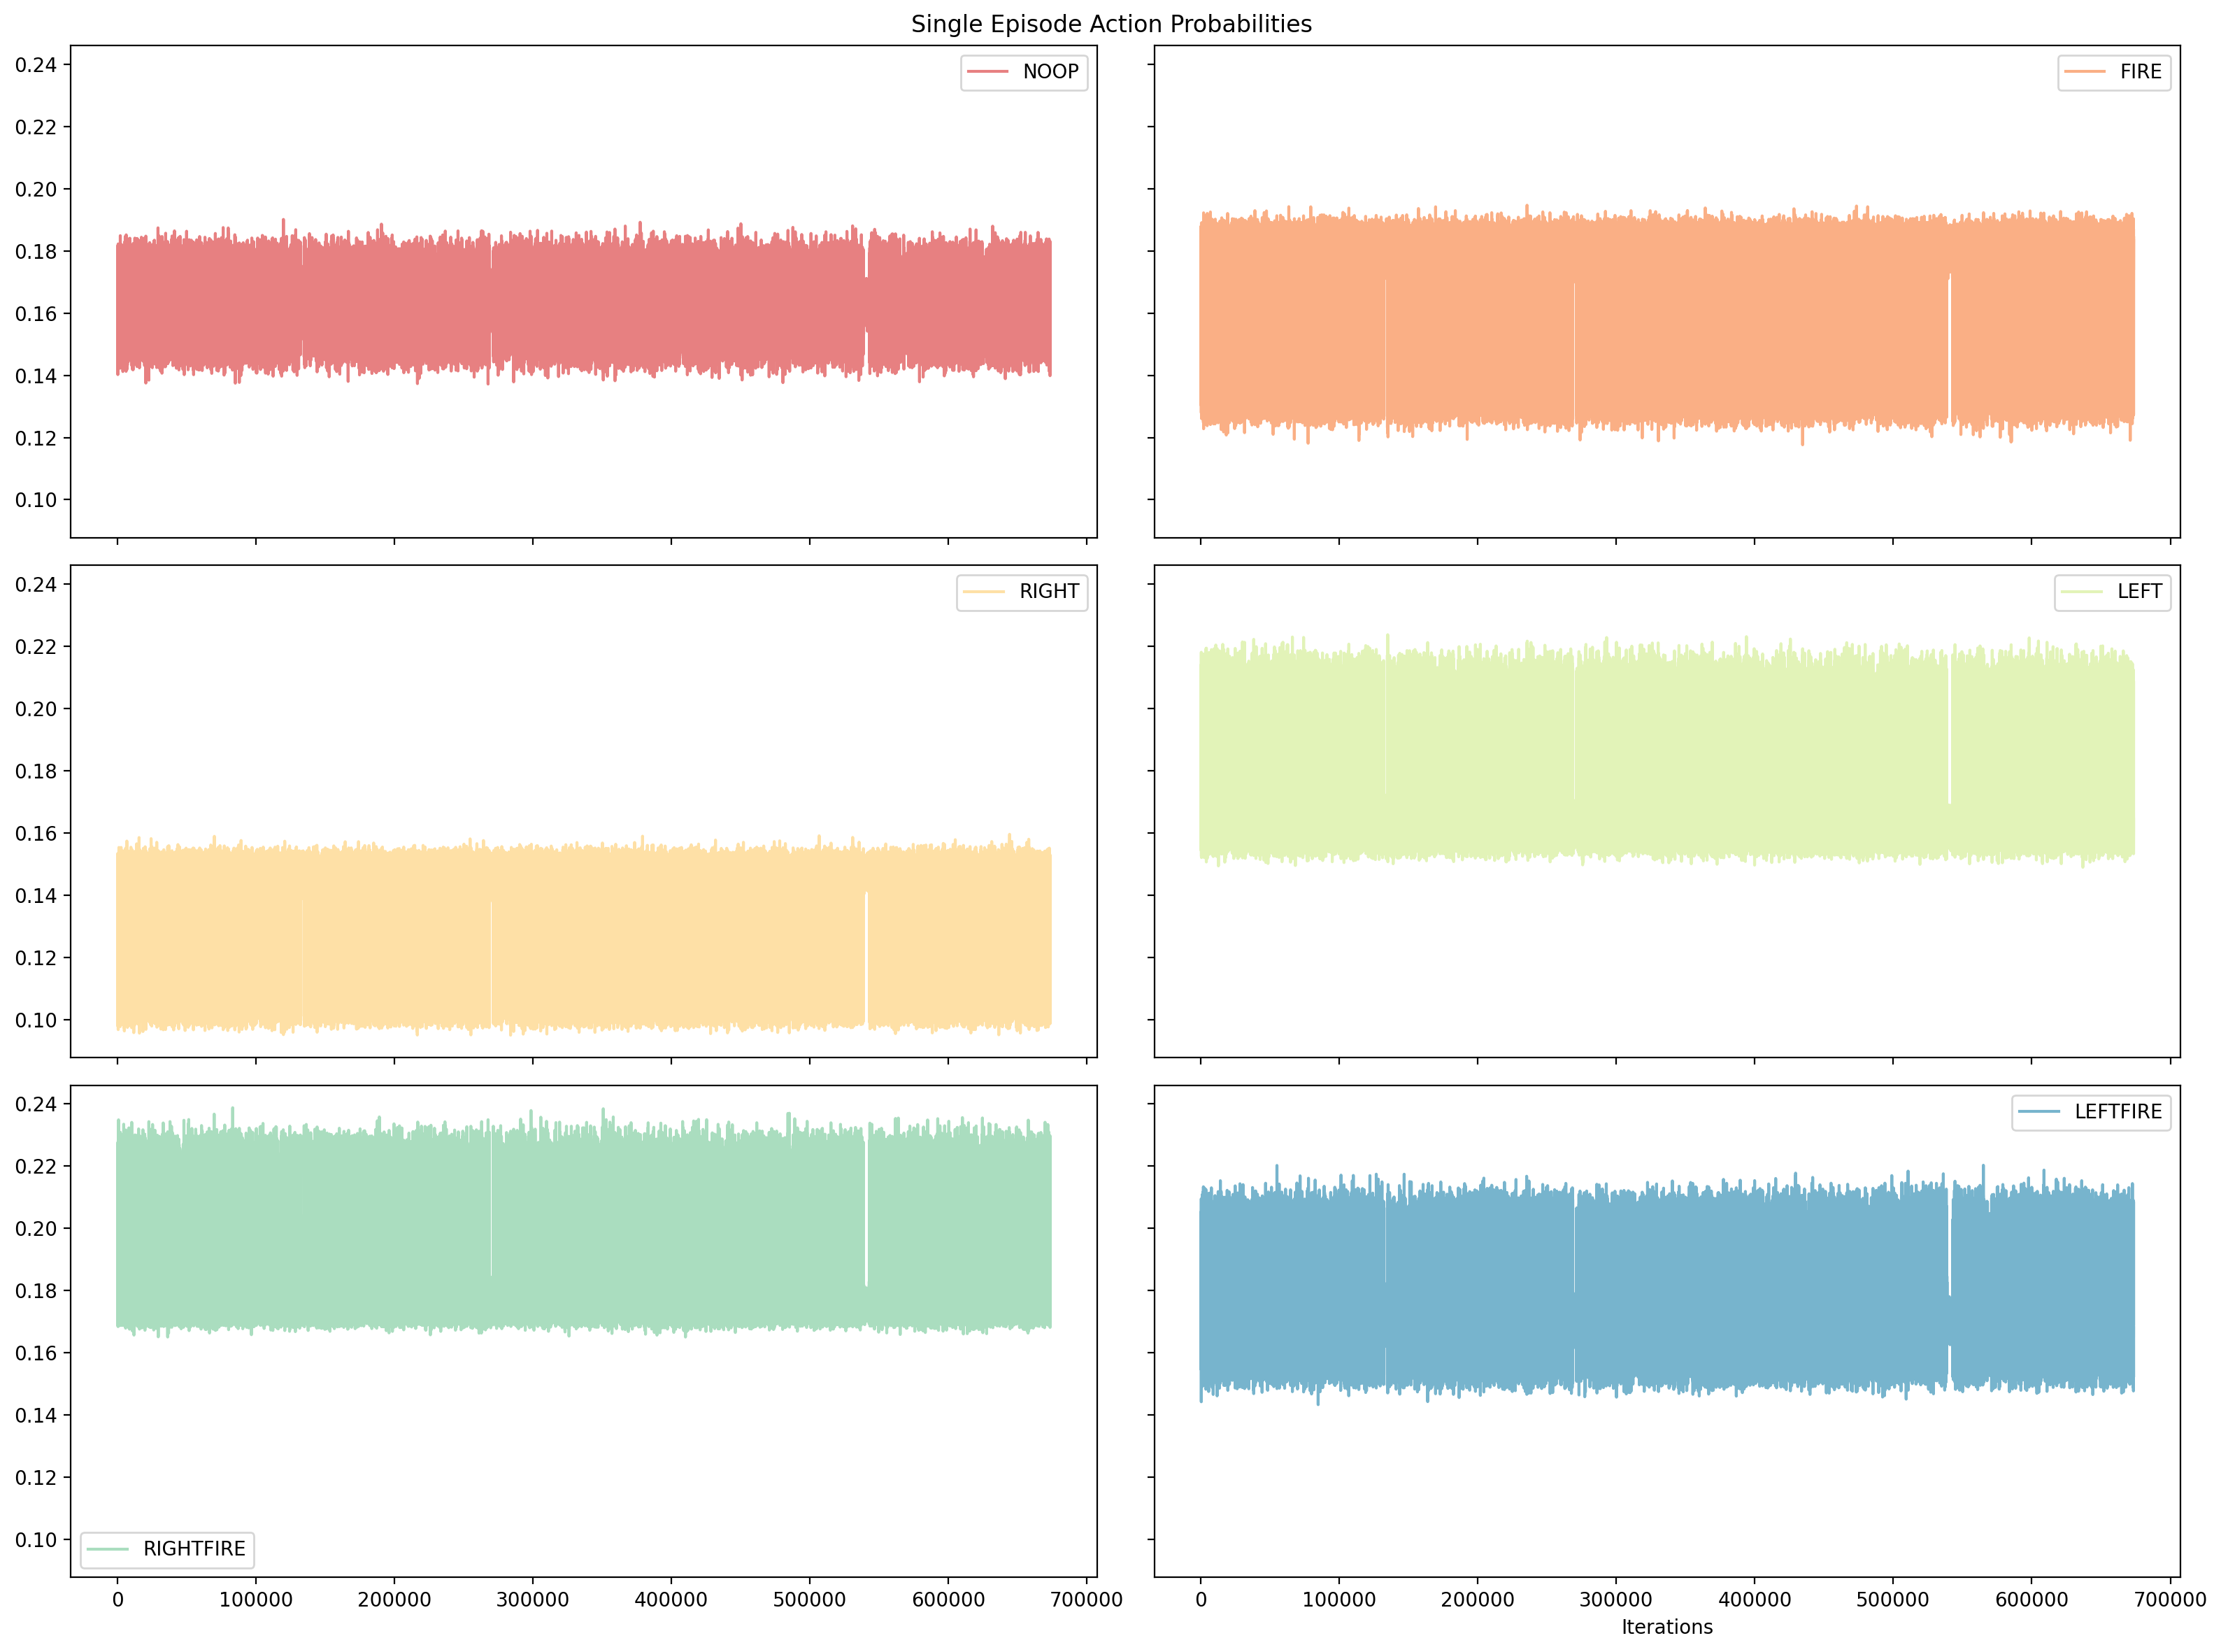

In [11]:
def plot_probs(prob_list, eps_iters_list, batch_size=64, step=1):
    probs_arr = torch.vstack(prob_list).detach().numpy()
    display(probs_arr.shape)
    
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(16,12), dpi=200, sharex=True, sharey=True)
    fig.suptitle('Single Episode Action Probabilities')
    colors = sns.color_palette('Spectral', 7)
    colors = colors[:3] + colors[4:]
    for i, (ax, color) in enumerate(zip(axs.flatten(), colors)):
        sns.lineplot(data=probs_arr[::step,i], color=color, label=action_dict[i], alpha=.7, dashes=False, ax=ax)
    plt.xlabel('Iterations')
    plt.ylabel('Probability')
    plt.tight_layout()
    plt.show()
    return

if record_probs:
    plot_probs(prob_list, eps_iters_list)

[80.0, 90.0, 50.0, 80.0, 175.0, 80.0, 10.0, 90.0, 70.0, 80.0, 90.0, 50.0, 130.0, 205.0, 70.0, 205.0, 120.0, 250.0, 150.0, 130.0, 20.0, 140.0, 120.0, 280.0, 70.0, 130.0, 120.0, 110.0, 280.0, 190.0, 110.0, 90.0, 235.0, 140.0, 60.0, 160.0, 120.0, 220.0, 150.0, 250.0, 160.0, 120.0, 150.0, 140.0, 130.0, 175.0, 150.0, 295.0, 100.0, 160.0, 70.0, 250.0, 205.0, 920.0, 235.0, 150.0, 130.0, 295.0, 120.0, 265.0, 220.0, 140.0, 110.0, 80.0, 190.0, 90.0, 120.0, 250.0, 175.0, 175.0, 190.0, 295.0, 150.0, 90.0, 130.0, 110.0, 100.0, 310.0, 80.0, 100.0, 175.0, 90.0, 130.0, 175.0, 120.0, 140.0, 120.0, 120.0, 90.0, 235.0, 50.0, 90.0, 355.0, 90.0, 130.0, 140.0, 100.0, 150.0, 90.0, 160.0, 220.0, 160.0, 280.0, 100.0, 60.0, 205.0, 280.0, 110.0, 220.0, 110.0, 100.0, 140.0, 20.0, 220.0, 280.0, 100.0, 150.0, 110.0, 50.0, 265.0, 130.0, 130.0, 100.0, 30.0, 80.0, 560.0, 40.0, 100.0, 190.0, 190.0, 100.0, 70.0, 340.0, 190.0, 150.0, 120.0, 90.0, 130.0, 100.0, 220.0, 340.0, 340.0, 80.0, 70.0, 160.0, 235.0, 130.0, 70.0, 2

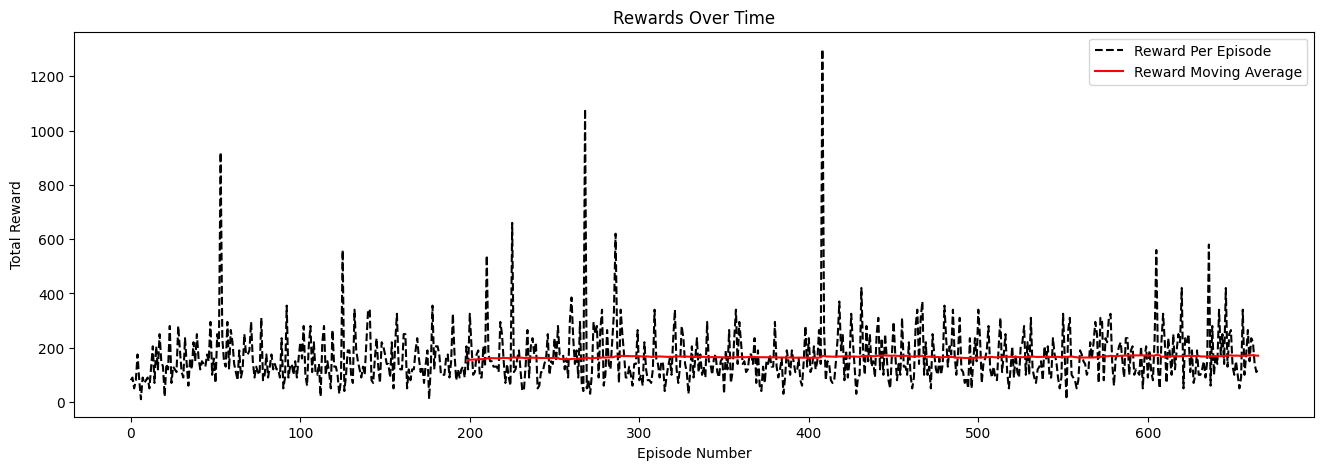

In [12]:
def moving_average(a, window_size) :
    ret = np.cumsum(a, dtype=float)
    ret[window_size:] = ret[window_size:] - ret[:-window_size]
    return ret[window_size - 1:] / window_size

def plot_rewards(reward_list, window_size=10):
    plt.figure(figsize=(16,5))
    plt.title('Rewards Over Time')
    plt.ylabel('Total Reward')
    plt.xlabel('Episode Number')
    x = np.arange(0, len(reward_list), 1)
    assert len(x) == len(reward_list)
    plt.plot(x, reward_list, color='black', linestyle='dashed', label='Reward Per Episode')
    plt.plot(x[window_size-1:], moving_average(reward_list, window_size), color='red', label='Reward Moving Average')
    plt.legend()
    plt.show()
    return

print(reward_list)
if record_rewards:
    plot_rewards(reward_list, window_size=200)